In [6]:
# Llamado de librerías 
# Codigo Hecho con cariño para la asignatura de Fundamentos de Dinamica de Fluidos Computacional, dictado por el profesor
# Christoper Cooper 2021-02 UTFSM - Universidad Técnica Federico Santa María 07/12/21
import numpy 
from math import pi 
from scipy import linalg
from scipy.linalg import solve
from scipy import sparse 
from scipy.sparse.linalg import spsolve 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
# Datos Iniciales
k = 1.4
gamma = 1.4 
x_min = 0 
x_max = 2
x_med = 1

N = 1500
dt = 0.0001 # 0.0005
dx = (x_max-x_min)/(N-1)

x = numpy.linspace(x_min,x_max,N)

rho = numpy.zeros(len(x))
u = numpy.zeros(len(x))
p = numpy.zeros(len(x))
E = numpy.zeros(len(x))



In [8]:
def CondInicial(x,gamma):
    for i in range(0,len(x)):
        x[i] = i*dx
     
        if (x[i] < 1):
            rho[i] = 1.0
            u[i] = 0.0
            p[i] = 1.2
        else:
            rho[i] = 0.125
            u[i] = 0.0
            p[i] = 0.1
        
        E[i] = p[i]/(gamma-1) + 0.5*rho[i]*u[i]**2
    return rho,u,p,E

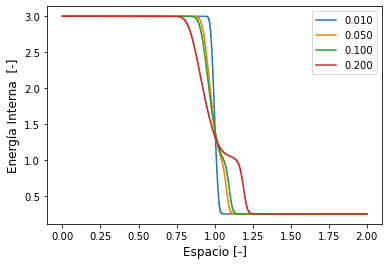

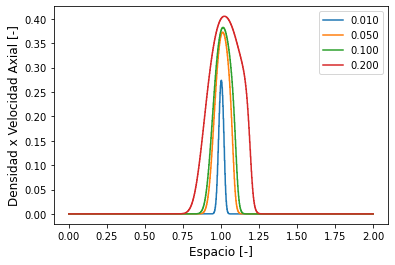

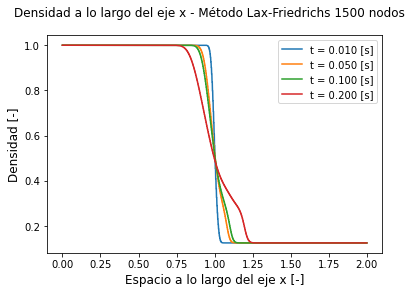

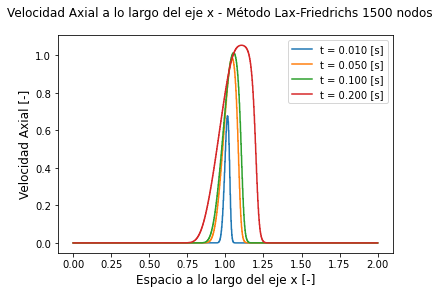

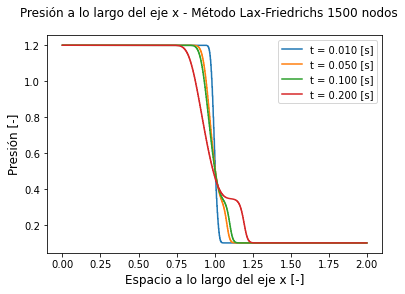

In [9]:
time = 0.
t_max = [0.01, 0.05, 0.1, 0.2]

#Creamos el cuerpo de los gráficos
fig1=plt.figure()
ax1=fig1.add_subplot(1,1,1)

plt.xlabel('Espacio [-]', fontsize=12)
plt.ylabel('Energía Interna  [-]', fontsize=12)

fig2=plt.figure()
ax2=fig2.add_subplot(1,1,1)
plt.xlabel('Espacio [-]', fontsize=12)
plt.ylabel('Densidad x Velocidad Axial [-]', fontsize=12)

fig3=plt.figure()
ax3=fig3.add_subplot(1,1,1)
fig3.suptitle('Densidad a lo largo del eje x - Método Lax-Friedrichs 1500 nodos')
plt.xlabel('Espacio a lo largo del eje x [-]', fontsize=12)
plt.ylabel('Densidad [-]', fontsize=12)

#!
fig7=plt.figure()
ax7=fig7.add_subplot(1,1,1)
fig7.suptitle('Velocidad Axial a lo largo del eje x - Método Lax-Friedrichs 1500 nodos')
plt.xlabel('Espacio a lo largo del eje x [-]', fontsize=12)
plt.ylabel('Velocidad Axial [-]', fontsize=12)
#!!

#!
fig8=plt.figure()
ax8=fig8.add_subplot(1,1,1)
fig8.suptitle('Presión a lo largo del eje x - Método Lax-Friedrichs 1500 nodos')
plt.xlabel('Espacio a lo largo del eje x [-]', fontsize=12)
plt.ylabel('Presión [-]', fontsize=12)
#!!

# Inicimos el loop para todos los tiempos solicitados
for i in range(len(t_max)): 
    U = numpy.zeros((len(x),3))
    F = numpy.zeros((len(x),3))
    rho,u,p,E = CondInicial(x,gamma)
    while (time < t_max[i]):
        U[:,0] = rho[:]
        U[:,1] = rho[:]*u[:]
        U[:,2] = E[:]
        
        F[:,0] = U[:,1]
        F[:,1] = rho[:]*u[:]*u[:] + p[:]
        F[:,2] = u[:]*(E[:] + p[:])
  ##LAX FRIEDRICHS
        Un = numpy.zeros((len(x),3)) 
        Un[1:len(x)-1,:] = 0.5*(U[0:len(x)-2,:]+U[2:len(x),:])-dt/(2*dx)*(F[2:len(x),:]-F[0:len(x)-2,:])
    #Condiciones de Borde 
        Un[0,:] = Un[1,:] #Neumann, gradiente = 0
        Un[len(x)-1,:] = Un[len(x)-2,:] #Neumann, gradiente = 0
  ##Reescritura de las variables en el instante dt*n
        time += dt
        U = Un

        rho[:] = Un[:,0]
        u = Un[:,1]/Un[:,0]
        E = Un[:,2]
        p = (gamma-1.0)*(E - 0.5*rho[:]*u[:]**2)
    
        
    
    ax1.plot(x,U[:,2], label='%1.3f'%time ,  )  #1 string 3 decimales, f = flotante % asigna la variable
    ax2.plot(x,U[:,1], label='%1.3f'%time )
    ax3.plot(x,U[:,0], label='t = ''%1.3f'%time+' [s]' )
    
    ax7.plot(x,U[:,1]/U[:,0], label='t = ''%1.3f'%time+' [s]' )
    ax7.legend()
    
    ax8.plot(x,p[:], label='t = ''%1.3f'%time+' [s]' )
    ax8.legend()
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

# Segundo Método: Richtmyer's

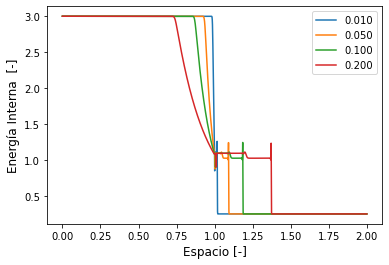

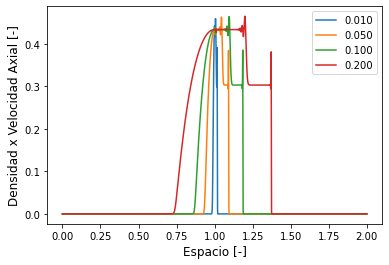

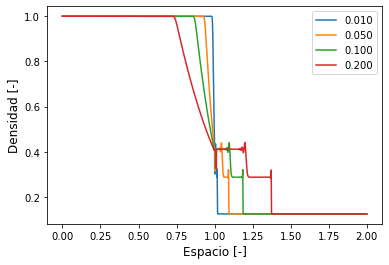

In [10]:
rhor = numpy.zeros(len(x))
ur = numpy.zeros(len(x))
pr = numpy.zeros(len(x))
Er = numpy.zeros(len(x))

time=0
t_max=[0.01, 0.05, 0.1, 0.2]
dt = 0.0005

# Inicialización gráficas
fig4=plt.figure()
ax4=fig4.add_subplot(1,1,1)
plt.xlabel('Espacio [-]', fontsize=12)
plt.ylabel('Energía Interna  [-]', fontsize=12)

fig5=plt.figure()
ax5=fig5.add_subplot(1,1,1)
plt.xlabel('Espacio [-]', fontsize=12)
plt.ylabel('Densidad x Velocidad Axial [-]', fontsize=12)

fig6=plt.figure()
ax6=fig6.add_subplot(1,1,1)
plt.xlabel('Espacio [-]', fontsize=12)
plt.ylabel('Densidad [-]', fontsize=12)

# Inicimos el loop para todos los tiempos solicitados

for i in range(len(t_max)):   
    time=0
    Ur = numpy.zeros((len(x),3)) 
    Fr = numpy.zeros((len(x),3))
    rhor,ur,pr,Er = CondInicial(x,gamma) 
    
    while (time < t_max[i]):  
        Ur[:,0] = rhor[:]
        Ur[:,1] = rhor[:]*ur[:]
        Ur[:,2] = Er[:]
        
        Fr[:,0] = Ur[:,1]
        Fr[:,1] = rhor[:]*ur[:]*ur[:] + pr[:]
        Fr[:,2] = ur[:]*(Er[:] + pr[:])
        
        ##Richmyers 
        
        ##Inicializamos matrices de paso 
        Umas = numpy.zeros((len(x),3)) 
        Umenos = numpy.zeros((len(x),3)) 
        Fmas = numpy.zeros((len(x),3)) 
        Fmenos = numpy.zeros((len(x),3)) 
        
        Umas[1:-1,:]=0.5*(Ur[2:,:]+Ur[1:-1,:])-(dt/(2*dx))*(Fr[2:,:]-Fr[1:-1,:])
        Umenos[1:-1,:]=0.5*(Ur[1:-1,:]+Ur[:-2,:])-(dt/(2*dx))*(Fr[1:-1,:]-Fr[:-2,:])
        
        ##Condiciones de borde de U, Neumann = 0 
        Umas[0,:] = Umas[1,:]
        Umas[-1,:] = Umas[-2,:]
        Umenos[0,:] = Umenos[1,:]
        Umenos[-1,:] = Umenos[-2,:]
        
        #Constantes para Fmas 
        rhor[:] = Umas[:,0] #
        ur[:] = Umas[:,1]/Umas[:,0]
        Er[:] = Umas[:,2]
        pr[:] = (gamma-1.0)*(Er[:] - 0.5*rhor[:]*ur[:]**2)
        
        ##Cálculo de Fmas 
        Fmas[:,0] = Umas[:,1]
        Fmas[:,1] = rhor[:]*ur[:]*ur[:] + pr[:]
        Fmas[:,2] = ur[:]*(Er[:] + pr[:])
        
        #Constante para Fmenos, reescribimos 
        rhor[:] = Umenos[:,0] #
        ur[:] = Umenos[:,1]/Umenos[:,0]
        Er[:] = Umenos[:,2]
        pr[:] = (gamma-1.0)*(Er[:] - 0.5*rhor[:]*ur[:]**2)
        
        ##Cálculo de Fmenos
        Fmenos[:,0] = Umenos[:,1]
        Fmenos[:,1] = rhor[:]*ur[:]*ur[:] + pr[:]
        Fmenos[:,2] = ur[:]*(Er[:] + pr[:])
        
        ##Corrección 
        Ur[1:-1,:]=Ur[1:-1,:]-(dt/dx)*(Fmas[1:-1,:]-Fmenos[1:-1,:])
        
        ##Condiciones de borde 
        Ur[0,:] = Ur[1,:]
        Ur[-1,:] = Ur[-2,:]
        
        #Reescribimos las constantes 
        rhor[:] = Ur[:,0] 
        ur[:] = Ur[:,1]/Ur[:,0]
        Er[:] = Ur[:,2]
        pr[:] = (gamma-1.0)*(Er[:] - 0.5*rhor[:]*ur[:]**2)
        
        time += dt
    
    ax4.plot(x,Ur[:,2], label='%1.3f'%time )  #1 string 3 decimales, f = flotante % asigna la variable
    ax5.plot(x,Ur[:,1], label='%1.3f'%time )
    ax6.plot(x,Ur[:,0], label='%1.3f'%time )
    ax4.legend()
    ax5.legend()
    ax6.legend()
        